# Practice 4 - Image and Text Bimodal Practice

## Steps to install kaggle API
#### 1. Create or loging into your kaggle account at https://www.kaggle.com/
#### 2. Go to your account (click on the right corner duck image)
#### 3. Download your kaggle.json file by creating a new API token 
#### 4. Copy the kaggle.json file into the .kaggle folder the installation of kaggle should created. The location will vary depending in you are using a Windows or MacOS/Linux machine

In [ ]:
!pip install kaggle
!pip install Keras-Preprocessing

In [13]:
# Instructions for MacOS/Linux Machine
!mkdir ~/.kaggle
!copy kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

The syntax of the command is incorrect.


#### Flickr 8K data set that contains 8K images and its correspondent caption. This dataset is designed for training and testing models used for captioning or image description tasks. The goal is to generate the appropriate captioning for the image at hand.

In [14]:
!kaggle datasets download sakshighadigaonkar/flickr-8k


  0%|          | 0.00/1.04G [00:00<?, ?B/s]
  0%|          | 1.00M/1.04G [00:00<07:17, 2.55MB/s]
  0%|          | 2.00M/1.04G [00:00<04:08, 4.47MB/s]
  0%|          | 3.00M/1.04G [00:00<03:08, 5.91MB/s]
  0%|          | 4.00M/1.04G [00:00<03:06, 5.95MB/s]
  1%|          | 6.00M/1.04G [00:00<02:11, 8.41MB/s]
  1%|          | 8.00M/1.04G [00:01<01:54, 9.67MB/s]
  1%|1         | 11.0M/1.04G [00:01<01:34, 11.7MB/s]
  1%|1         | 13.0M/1.04G [00:01<01:22, 13.3MB/s]
  2%|1         | 16.0M/1.04G [00:01<01:09, 15.8MB/s]
  2%|1         | 18.0M/1.04G [00:01<01:04, 16.9MB/s]
  2%|1         | 20.0M/1.04G [00:02<01:45, 10.3MB/s]
  2%|2         | 25.0M/1.04G [00:02<01:10, 15.4MB/s]
  3%|2         | 27.0M/1.04G [00:02<01:07, 16.1MB/s]
  3%|2         | 29.0M/1.04G [00:02<01:05, 16.7MB/s]
  3%|2         | 31.0M/1.04G [00:02<01:01, 17.5MB/s]
  3%|3         | 33.0M/1.04G [00:02<01:02, 17.3MB/s]
  3%|3         | 36.0M/1.04G [00:02<01:00, 17.8MB/s]
  4%|3         | 39.0M/1.04G [00:03<00:56, 19.1MB/s]
 

#### Glove6b is a data set of Pre-trained word vectors using GloVe model. More info: https://nlp.stanford.edu/projects/glove/

In [16]:
!kaggle datasets download yesornope/glove6b

glove6b.zip: Skipping, found more recently modified local copy (use --force to force download)


In [17]:
# Instructions to unzip data set zip files
!unzip flickr-8k.zip
!unzip glove6b.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [21]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

In [155]:
token_path = "./flickr-8k/Flickr8k_text/Flickr8k.token.txt"
train_images_path = './flickr-8k/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = './flickr-8k/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = './flickr-8k/Flickr8k_Dataset/Flicker8k_Dataset'

doc = open(token_path,'r').read()

In [34]:
doc[:500]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7'

In [35]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [178]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

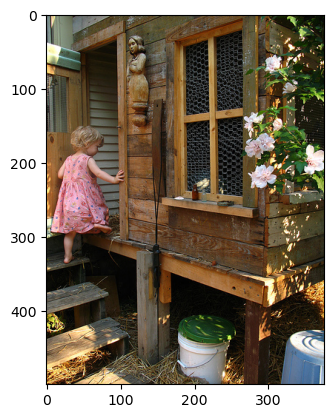

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [36]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+'/'+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [38]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d words' % len(vocabulary))

Original Vocabulary Size: 9630 words


In [44]:
# Let us see the first 10 words of our vocabulary.
list(vocabulary)[0:10]

['armstand',
 'table',
 'archways',
 'gymnasium',
 'competes',
 'showroom',
 'swimmers',
 'fur',
 'backstrokes',
 'tips']

In [52]:
## Manipulation of the descriptions to prepare them to join them with their correspondent images
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [53]:
## Collects in train the images we are going to use for training purposes.
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [67]:
#In this case we are going to actually get the images and stored them in train_img list
img = glob.glob(images_path + '/*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img:
    if i.split('/')[-1].split('\\')[-1] in train_images: ## .split('\\')[-1] this is added if you run this in a windows machine. Remove it if you are running in MacOS/Linux machine
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i.split('/')[-1].split('\\')[-1] in test_images:  ## .split('\\')[-1] this is added if you run this in a windows machine. Remove it if you are running in MacOS/Linux machine
        test_img.append(i)

In [68]:
len(train_img)

6000

In [70]:
train_img[0:5]

['./flickr-8k/Flickr8k_Dataset/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 './flickr-8k/Flickr8k_Dataset/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 './flickr-8k/Flickr8k_Dataset/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 './flickr-8k/Flickr8k_Dataset/Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 './flickr-8k/Flickr8k_Dataset/Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [69]:
len(test_img)

1000

In [71]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq' # adding the start and end sequence tokens for latter transformation
        train_descriptions[image_id].append(desc)

In [75]:
train_descriptions['1000268201_693b08cb0e']

['startseq A child in a pink dress is climbing up a set of stairs in an entry way . endseq',
 'startseq A girl going into a wooden building . endseq',
 'startseq A little girl climbing into a wooden playhouse . endseq',
 'startseq A little girl climbing the stairs to her playhouse . endseq',
 'startseq A little girl in a pink dress going into a wooden cabin . endseq']

In [76]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [179]:
all_train_captions[0:10]

['startseq A child in a pink dress is climbing up a set of stairs in an entry way . endseq',
 'startseq A girl going into a wooden building . endseq',
 'startseq A little girl climbing into a wooden playhouse . endseq',
 'startseq A little girl climbing the stairs to her playhouse . endseq',
 'startseq A little girl in a pink dress going into a wooden cabin . endseq',
 'startseq A black dog and a spotted dog are fighting endseq',
 'startseq A black dog and a tri-colored dog playing with each other on the road . endseq',
 'startseq A black dog and a white dog with brown spots are staring at each other in the street . endseq',
 'startseq Two dogs of different breeds looking at each other on the road . endseq',
 'startseq Two dogs on pavement moving toward each other . endseq']

In [82]:
## Filtering out less relevant words from our description vocabulary. 
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
        
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary szie for words that have 10 or more occurrences= %d' % (len(vocab)))

Vocabulary szie for words that have 10 or more occurrences= 1698


In [83]:
vocab[0:10]

['startseq', 'A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up']

In [84]:
# we build up our mapping to map each word to an index.

ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [87]:
vocab_size

1699

In [88]:
# we capture the longest description in our description data set.
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 40


# Text encoding process

In [90]:
glove_path = './glove6b/'

embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [97]:
print('the',embeddings_index['the'])
print('child',embeddings_index['child'])

the [-7.1549e-02  9.3459e-02  2.3738e-02 -9.0339e-02  5.6123e-02  3.2547e-01
 -3.9796e-01 -9.2139e-02  6.1181e-02 -1.8950e-01  1.3061e-01  1.4349e-01
  1.1479e-02  3.8158e-01  5.4030e-01 -1.4088e-01  2.4315e-01  2.3036e-01
 -5.5339e-01  4.8154e-02  4.5662e-01  3.2338e+00  2.0199e-02  4.9019e-02
 -1.4132e-02  7.6017e-02 -1.1527e-01  2.0060e-01 -7.7657e-02  2.4328e-01
  1.6368e-01 -3.4118e-01 -6.6070e-02  1.0152e-01  3.8232e-02 -1.7668e-01
 -8.8153e-01 -3.3895e-01 -3.5481e-02 -5.5095e-01 -1.6899e-02 -4.3982e-01
  3.9004e-02  4.0447e-01 -2.5880e-01  6.4594e-01  2.6641e-01  2.8009e-01
 -2.4625e-02  6.3302e-01 -3.1700e-01  1.0271e-01  3.0886e-01  9.7792e-02
 -3.8227e-01  8.6552e-02  4.7075e-02  2.3511e-01 -3.2127e-01 -2.8538e-01
  1.6670e-01 -4.9707e-03 -6.2714e-01 -2.4904e-01  2.9713e-01  1.4379e-01
 -1.2325e-01 -5.8178e-02 -1.0290e-03 -8.2126e-02  3.6935e-01 -5.8442e-04
  3.4286e-01  2.8426e-01 -6.8599e-02  6.5747e-01 -2.9087e-02  1.6184e-01
  7.3672e-02 -3.0343e-01  9.5733e-02 -5.2860e-0

In [115]:
#Now for every single words stored in our mapping word to index (wordtoix), we obtain its embedding representation from Glove pretrain vectors
# and we create our embedding matrix where index i contains the embedding vector of word with index i. Our matrix dimension will be defined as 
# vocab_size (1699) and 200 embeedings based on the specific pretrained vector data set we are using. 
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [117]:
print(len(embedding_matrix))
print(embedding_matrix[0].size)

1699
200


wordtoix --> given a word returns its index
ixtoword --> given an index returns its word
embedding_matrix --> given an index returns its embeddings.

# Image encoding process

In [119]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

96112376/96112376 [==============================] - 5s 0us/step


In [125]:
from tensorflow.keras.utils import load_img, img_to_array

def preprocess(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [121]:
print(len(train_img))

6000


In [122]:
len(test_img)

1000

In [123]:
train_img = train_img[0:100]
test_img = test_img[0:50]

In [124]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img] = encode(img)

1/1 [==============================] - 0s 114ms/step


# Bimodal model 

In [126]:
inputs1 = Input(shape=(2048,)) # Image input
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,)) # text input
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3]) # join modality --> Additive fusion
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 200)      339800      ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_3[0][0]']                
                                                                                            

In [127]:
model.layers[2].set_weights([embedding_matrix]) # Setting up the weigths of embedding layer as the weights obtained after appliying Glove pretained vectors
model.layers[2].trainable = False # we make the layer not trainable as we do not want that the model updates/learns anything from the inference generated.

In [128]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [164]:
# generates the actual input pair and output by combining each photo with each of its captions and use another caption as output. 
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[images_path + '\\' + key + '.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [130]:
len(train_descriptions)

6000

In [131]:
train_descriptions["2918880895_e61f74f2f0"]

['startseq A man in a yellow and yellow shirt puts his arm around a man in a blue shirt . endseq',
 'startseq A man in a yellow shirt and a man in a blue shirt and tie posing for a picture . endseq',
 'startseq Two employees pose for a picture . endseq',
 'startseq Two guys , one black and one white , smiling for the camera . endseq',
 'startseq Two men each have one arm around each other and are in formal dresswear endseq']

In [142]:
len(train_features)

100

In [139]:
train_features['./flickr-8k/Flickr8k_Dataset/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg']

array([0.12277621, 0.33294916, 0.752717  , ..., 0.21939674, 0.30216426,
       0.4028325 ], dtype=float32)

In [140]:
train_descriptions_100 = {}
import os

for key, item in train_features.items():
  key = os.path.basename(key)
  key = key.split(".")
  train_descriptions_100[key[0]] = train_descriptions[key[0]]

In [141]:
train_descriptions_100['1000268201_693b08cb0e']

['startseq A child in a pink dress is climbing up a set of stairs in an entry way . endseq',
 'startseq A girl going into a wooden building . endseq',
 'startseq A little girl climbing into a wooden playhouse . endseq',
 'startseq A little girl climbing the stairs to her playhouse . endseq',
 'startseq A little girl in a pink dress going into a wooden cabin . endseq']

In [181]:
epochs = 15
batch_size = 3
steps = len(train_descriptions_100)//batch_size
generator = data_generator(train_descriptions_100, train_features, wordtoix, max_length, batch_size)


In [182]:
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/15
33/33 [==============================] - 8s 234ms/step - loss: 1.7011
Epoch 2/15
33/33 [==============================] - 8s 251ms/step - loss: 1.5685
Epoch 3/15
33/33 [==============================] - 10s 306ms/step - loss: 1.5006
Epoch 4/15
33/33 [==============================] - 10s 308ms/step - loss: 1.4419
Epoch 5/15
33/33 [==============================] - 11s 332ms/step - loss: 1.4318
Epoch 6/15
33/33 [==============================] - 11s 315ms/step - loss: 1.3710
Epoch 7/15
33/33 [==============================] - 11s 330ms/step - loss: 1.3248
Epoch 8/15
33/33 [==============================] - 11s 323ms/step - loss: 1.2754
Epoch 9/15
33/33 [==============================] - 11s 324ms/step - loss: 1.2027
Epoch 10/15
33/33 [==============================] - 10s 320ms/step - loss: 1.1505
Epoch 11/15
33/33 [==============================] - 11s 328ms/step - loss: 1.1033
Epoch 12/15
33/33 [==============================] - 11s 340ms/step - loss: 1.0869
Epoch 13/15
33/

In [171]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        print(word)
        in_text += ' ' + word
        print(in_text)
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [176]:
from keras_preprocessing.sequence import pad_sequences

def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    print(start_word)
    start_word = start_word[-1][0]
    print(start_word)
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

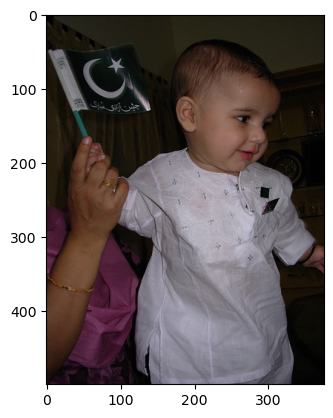

[[4.5889280e-08 5.9925441e-08 4.3170279e-01 ... 4.8047543e-08
  3.9629644e-08 1.8229984e-07]]
A
startseq A
[[1.9039641e-07 4.3998074e-07 1.3458771e-03 ... 2.6303610e-07
  2.5256620e-07 7.4517408e-07]]
young
startseq A young
[[1.5588666e-10 5.6803001e-10 1.9670915e-05 ... 1.3458920e-10
  2.1782615e-10 5.0487342e-10]]
girl
startseq A young girl
[[1.2290595e-09 7.2884161e-09 6.6156796e-09 ... 7.7248519e-10
  8.6672509e-09 8.8489083e-09]]
is
startseq A young girl is
[[3.83577836e-09 5.58646960e-08 7.10780634e-09 ... 6.63667521e-09
  1.43383776e-08 1.47982675e-08]]
upside
startseq A young girl is upside
[[3.30806632e-11 1.12441056e-10 8.82739628e-12 ... 1.27866204e-10
  1.20059171e-10 2.47122406e-10]]
on
startseq A young girl is upside on
[[3.6806555e-10 4.4803980e-10 1.6849629e-10 ... 8.6735824e-10
  1.2186809e-10 8.1065477e-10]]
a
startseq A young girl is upside on a
[[5.0085962e-08 2.2583018e-07 5.6263293e-06 ... 1.0249879e-07
  2.9029636e-08 1.1395659e-07]]
bed
startseq A young girl is 

In [185]:
pic = list(encoding_test.keys())[7]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))